# Logistic Regression

## 1. Environment setup

In [2]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

Python version: 3.6.15


In [3]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [4]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report

scikit-learn version: 0.24.2


In [5]:
def plot_data(x, y):
    """Plot some 2D data"""

    fig, ax = plt.subplots()
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
    ax.add_artist(legend1)
    plt.xlim((min(x[:, 0]) - 0.1, max(x[:, 0]) + 0.1))
    plt.ylim((min(x[:, 1]) - 0.1, max(x[:, 1]) + 0.1))


def plot_decision_boundary(pred_func, x, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
    plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)

## 2. Binary classification

### Problem formulation

Logistic regression is a classification algorithm used to estimate the probability that a data sample belongs to a particular class.

A logistic regression model computes a weighted sum of the input features (plus a bias term), then applies the [logistic function](activations:sigmoid) to this sum in order to output a probability.

$$y' = \mathcal{h}_\theta(\pmb{x}) = \sigma(\pmb{\theta}^T\pmb{x})$$

The function output is thresholded to form the model's prediction:

- $0$ if $y' \lt 0.5$
- $1$ if $y' \geqslant 0.5$

### Loss function: Binary Crossentropy (log loss)

See [loss definition](loss:bce) for details.

### Model training

- No analytical solution because of the non-linear $\sigma()$ function: gradient descent is the only option.
- Since the loss function is convex, GD (with the right hyperparameters) is guaranteed to find the global loss minimum.
- Different GD optimizers exist: *newton-cg*, *l-bfgs*, *sag*... *Stochastic gradient descent* is another possibility, efficient for large numbers of samples and features.

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\boldsymbol{\theta})
     \end{pmatrix} = \frac{2}{m}\pmb{X}^T\left(\sigma(\pmb{X}\pmb{\theta}) - \pmb{y}\right)$$

### Example: classify planar data

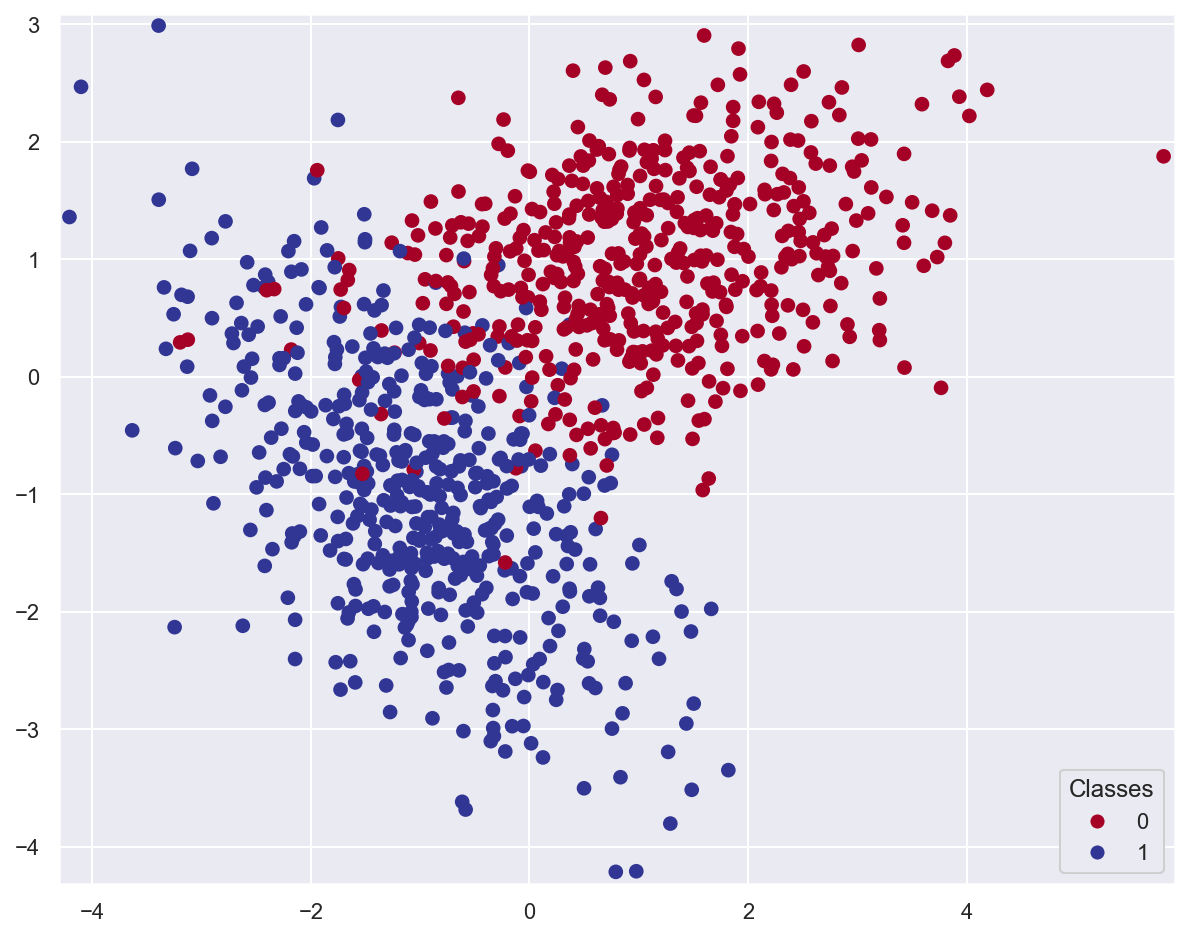

In [6]:
# Generate 2 classes of linearly separable data
x_train, y_train = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=26,
    n_clusters_per_class=1,
)
plot_data(x_train, y_train)

In [7]:
# Create a Logistic Regression model based on stochastic gradient descent
# Alternative: using the LogisticRegression class which implements many GD optimizers
lr_model = SGDClassifier(loss="log")

# Train the model
lr_model.fit(x_train, y_train)

print(f"Model weights: {lr_model.coef_}, bias: {lr_model.intercept_}")

Model weights: [[-2.13074052 -2.84539508]], bias: [-0.76743375]


In [8]:
# Print report with classification metrics
y_train_pred = lr_model.predict(x_train)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       502
           1       0.94      0.95      0.94       498

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



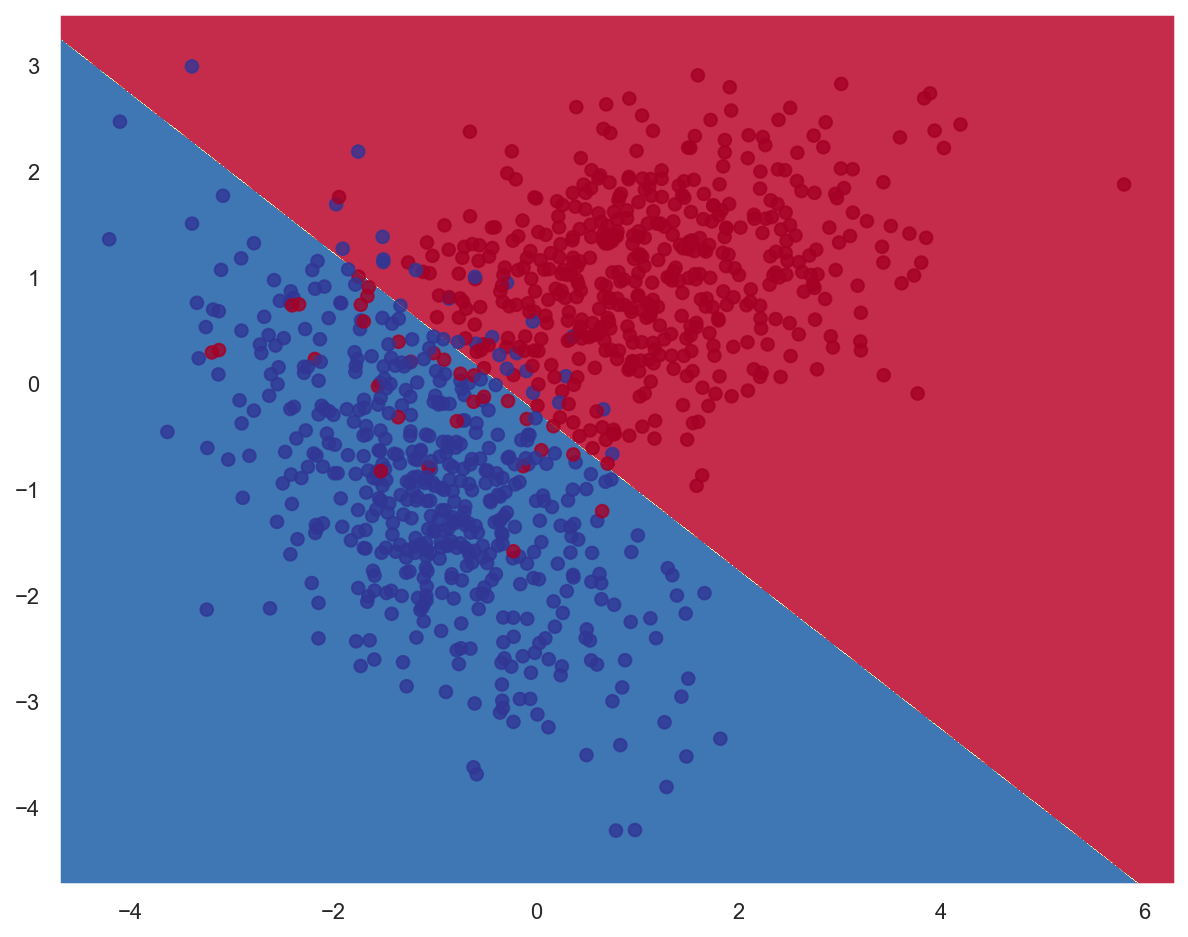

In [9]:
# Plot decision boundary
plot_decision_boundary(lambda x: lr_model.predict(x), x_train, y_train)

### Metrics

The [article](https://towardsdatascience.com/finally-remember-what-precision-and-recall-is-and-stop-being-afraid-of-these-questions-in-f61981930c67) explains TP, FP, TN, FN, Precision, Recall and F1-measure. 

<img src="https://miro.medium.com/max/1050/1*nIpdlP7zWboF-4omRrwLRg.jpeg">

### Different Thresholds Lead to Different Quality

Logistic regression returns a probability. You can use the returned probability "as is" (for example, "the probability that the user will click on this ad is 0.00023") or convert the returned probability to a binary value (for example, "this email is spam").

Function `model.predict_proba` outputs probabilities for all classes, while `model.predict`(that was used above) returns class predictions (it uses threshold of 0.5 by default). For more details about API refer to [SGDClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). Generally, `threshold=0.5` is not always the best choice, so it is better to use probabilities directly.

In order to map a logistic regression probabilities to a binary category, you must define a classification threshold (also called the decision threshold). A value above that threshold indicates "spam"; a value below indicates "not spam." 

Note: Part of choosing a threshold is assessing how much you'll suffer for making a mistake. For example, mistakenly labeling a non-spam message as spam is very bad. However, mistakenly labeling a spam message as non-spam is unpleasant, but hardly the end of your job.

In [23]:
def get_predictions(lr_model, x, threshold: float = 0.5) -> np.array:
    # The function
    #   - calculates probabilities of classes for samples from x
    #   - converts then to class predictions with specific threshold
    #
    # Example:
    #      y_prob = [[0.1, 0.9], [0.6, 0.4]]   ->   y_pred = [1, 0]
    #

    ### YOUR CODE HERE


    ###
    
    return (lr_model.predict_proba(x)[:,1:]>threshold).astype("int")

# Print report with classification metrics
y_train_pred = get_predictions(lr_model, x_train, threshold=0.5)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       502
           1       0.94      0.95      0.94       498

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [24]:
y_train_pred = get_predictions(lr_model, x_train, threshold=0.1)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       502
           1       0.85      0.99      0.91       498

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



In [25]:
y_train_pred = get_predictions(lr_model, x_train, threshold=0.9)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       502
           1       0.98      0.77      0.86       498

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.87      1000
weighted avg       0.89      0.88      0.87      1000

